# Modeling

## Setup

In [2]:
# import required packages

# data analysis
import pandas as pd
import numpy as np
import time

# preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

# modeling and evaluating
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate#, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV #Perforing grid search

# visualizatio
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4



data_path='../data/loan.csv' #change to your own folder of data

Using TensorFlow backend.


In [3]:
# load data
df = pd.read_csv(data_path)

/Users/xchen/opt/anaconda3/envs/ds_37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Impute Missing Values

In [4]:
# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    
df['region'] = df['addr_state'].apply(finding_regions)

In [5]:
cols = ['annual_inc','dti','delinq_2yrs', 'inq_last_6mths', 'total_acc','open_acc','pub_rec']
for col in cols:
    df[col]=df.groupby("region")[col].transform(lambda x: x.fillna(x.median()))

cols = ['revol_util','mths_since_last_delinq','mths_since_last_record']
for col in cols:
    df[col] = df[col].fillna(0)

In [6]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period",
            "Late (16-30 days)", "Late (31-120 days)"]

def loan_condition(status):
    if status in bad_loan:
        return 1
    else:
        return 0

df['is_bad'] = np.nan
df['is_bad'] = df['loan_status'].apply(loan_condition)
df.drop(['loan_status'],axis=1, inplace=True)

In [7]:
selected_cols = ['is_bad', 'funded_amnt', 'term', 'grade',
                 'int_rate', 'installment', 'purpose', 'pymnt_plan', 
                 'revol_bal','revol_util', 
                 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_rec_prncp', 'total_rec_int',
                 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                 'home_ownership', 'annual_inc','verification_status', 'addr_state', 
                 'dti', 'delinq_2yrs', 'inq_last_6mths',
                 'total_acc', 'open_acc', 'pub_rec', 'mths_since_last_delinq', 'mths_since_last_record'
                 ]
df_selected = df[selected_cols].copy()

In [8]:
df_selected.isna().sum().max()

0

In [9]:
df_selected.dtypes

is_bad                       int64
funded_amnt                  int64
term                        object
grade                       object
int_rate                   float64
installment                float64
purpose                     object
pymnt_plan                  object
revol_bal                    int64
revol_util                 float64
out_prncp                  float64
out_prncp_inv              float64
total_pymnt                float64
total_rec_prncp            float64
total_rec_int              float64
total_rec_late_fee         float64
recoveries                 float64
collection_recovery_fee    float64
home_ownership              object
annual_inc                 float64
verification_status         object
addr_state                  object
dti                        float64
delinq_2yrs                float64
inq_last_6mths             float64
total_acc                  float64
open_acc                   float64
pub_rec                    float64
mths_since_last_deli

## Preprocessing

### Split the dataset

The original data is imbalanced and the bad loan is the minority class.

In [10]:
# Number of bad loans
print(len(df_selected['is_bad']))
# Loan Ratios (Imbalanced classes)
print(df_selected['is_bad'].value_counts()/len(df_selected['is_bad']))

2260668
0    0.868608
1    0.131392
Name: is_bad, dtype: float64


Apply StratifiedShuffleSplit to split the dataset into train and test sets randomly ensuring that both sets have the same ration of bad loans.

In [11]:
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(df_selected, df_selected["is_bad"]):
    stratified_train = df_selected.loc[train_set]
    stratified_test = df_selected.loc[test_set]
    
print('Train set ratio \n', stratified_train["is_bad"].value_counts()/len(stratified_train))
print('Test set ratio \n', stratified_test["is_bad"].value_counts()/len(stratified_test))

Train set ratio 
 0    0.868608
1    0.131392
Name: is_bad, dtype: float64
Test set ratio 
 0    0.868608
1    0.131392
Name: is_bad, dtype: float64


In [12]:
train_df = stratified_train
test_df = stratified_test


# Let's Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)


# Train set (Normal training dataset)
X_train = train_df.drop('is_bad', axis=1)
y_train = train_df['is_bad']


# Test Dataset
X_test = test_df.drop('is_bad', axis=1)
y_test = test_df['is_bad']

### Features Encoding and Scaling

In [13]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [14]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [15]:
numeric = X_train.select_dtypes(exclude=["object"])
categorical = X_train.select_dtypes(["object"])

numeric_pipeline = Pipeline([
    ('selector', DataFrameSelector(numeric.columns.tolist())),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical.columns.tolist())), # We will have to write the categorical columns manually and see if it works.
    ('encoder', CategoricalEncoder(encoding="onehot-dense")),
])

# Combine both Pipelines into one array
combined_pipeline = FeatureUnion(transformer_list=[
    ('numeric_pipeline', numeric_pipeline),
    ('categorical_pipeline', categorical_pipeline)
])

X_train = combined_pipeline.fit_transform(X_train)
X_test = combined_pipeline.fit_transform(X_test)

In [16]:
print('Train data: ',type(X_train),X_train.shape)
print('Test data: ',type(X_test),X_test.shape)

Train data:  <class 'numpy.ndarray'> (1808534, 107)
Test data:  <class 'numpy.ndarray'> (452134, 107)


## Oversampling

In [17]:
# Oversampled Train Set 
starting_time = time.time()
sm = SMOTE(sampling_strategy='minority', random_state=42, n_jobs = -1)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
ending_time = time.time()
print("Resampling the data took: {:.2f} minutes!".format(round((ending_time - starting_time)/60), 2))

Resampling the data took: 24.00 minutes!


In [19]:
np.asarray(np.unique(y_train_sm, return_counts=True)).T

array([[      0, 1570908],
       [      1, 1570908]])

## Modeling

### Logistic Regression

In [21]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/xchen/opt/anaconda3/envs/ds_37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
normal_ypred_lr = lr.predict(X_test)
print("Train score: %f" % lr.score(X_train, y_train))
print("Test score: %f" % lr.score(X_test, y_test))

Train score: 0.983871
Test score: 0.983927


In [24]:
normal_pred_lr_train = lr.predict_proba(X_train)[:,1]
normal_pred_lr_test = lr.predict_proba(X_test)[:,1]

print('Train AUC: ', roc_auc_score(y_train, normal_pred_lr_train))
print('Test AUC: ', roc_auc_score(y_test, normal_pred_lr_test))

Train AUC:  0.9794368903427
Test AUC:  0.9799586371236347


In [25]:
target_names = ['Good Loan', 'Bad Loan']
print(classification_report(y_test, normal_ypred_lr, target_names=target_names))

              precision    recall  f1-score   support

   Good Loan       0.98      1.00      0.99    392727
    Bad Loan       1.00      0.88      0.94     59407

    accuracy                           0.98    452134
   macro avg       0.99      0.94      0.96    452134
weighted avg       0.98      0.98      0.98    452134



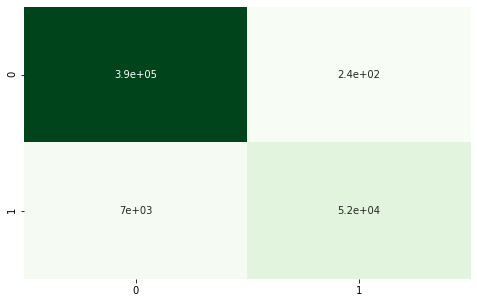

In [40]:
plt.figure(figsize=(8,5))
normal_lr_cm=confusion_matrix(y_test, normal_ypred_lr)
sns.heatmap(normal_lr_cm, annot = True, cmap="Greens",cbar=False)

<h4> SMOTE Sampling</h4>

In [36]:
lr_sm = LogisticRegression()
lr_sm.fit(X_train_sm, y_train_sm)

/Users/xchen/opt/anaconda3/envs/ds_37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
smote_ypred_lr = lr_sm.predict(X_test)
print("Train score: %f" % lr_sm.score(X_train_sm, y_train_sm))
print("Test score: %f" % lr_sm.score(X_test, y_test))

Train score: 0.958065
Test score: 0.979382


In [38]:
smote_pred_lr_train = lr_sm.predict_proba(X_train_sm)[:,1]
smote_pred_lr_test = lr_sm.predict_proba(X_test)[:,1]

print('Train AUC: ', roc_auc_score(y_train_sm, smote_pred_lr_train))
print('Test AUC: ', roc_auc_score(y_test, smote_pred_lr_test))

Train AUC:  0.9880314000620045
Test AUC:  0.9801059989110401


In [42]:
target_names = ['Good Loan', 'Bad Loan']
print(classification_report(y_test, smote_ypred_lr, target_names=target_names))

              precision    recall  f1-score   support

   Good Loan       0.98      0.99      0.99    392727
    Bad Loan       0.94      0.90      0.92     59407

    accuracy                           0.98    452134
   macro avg       0.96      0.94      0.95    452134
weighted avg       0.98      0.98      0.98    452134



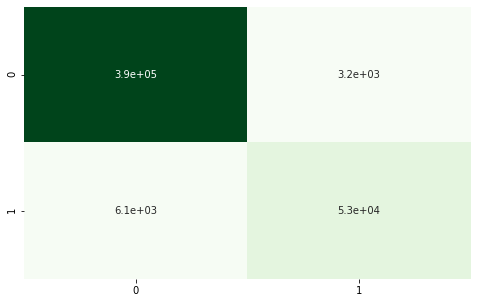

In [41]:
plt.figure(figsize=(8,5))
smote_lr_cm=confusion_matrix(y_test, smote_ypred_lr)
sns.heatmap(smote_lr_cm, annot = True, cmap="Greens",cbar=False)

In [ ]:
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)
plt.plot(fpr_lr, tpr_lr, linewidth=2, label='logistic regression(auc = {:0.2f})'.format(roc_auc_lr)) 

### XGBoost

In [22]:
def modelfit(model, Xtrain, ytrain, Xtest, ytest, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(Xtrain, label=ytrain)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=model.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval = 20
                         )
        model.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the model on the data
    model.fit(Xtrain, ytrain,eval_metric='auc')
        
    #Predict training set:
    xgb_pred_train = model.predict(Xtrain)
    xgb_pred_test = model.predict(Xtest)
    xgb_predprob_train = model.predict_proba(Xtrain)[:,1]
    xgb_predprob_test = model.predict_proba(Xtest)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(ytrain, xgb_pred))
    print ("Recall (train) : %.4g" % recall_score(ytrain, xgb_pred_train))
    print ("Recall (test) : %.4g" % recall_score(ytest, xgb_pred_test))
    print ("AUC Score (Train): %f" % roc_auc_score(ytrain, xgb_predprob_train))
    print ("AUC Score (Test): %f" % roc_auc_score(ytest, xgb_predprob_test))
                    
    feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

<h4>Set initial parameters:</h4>

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train_sm, y_train_sm, X_test, y_test)

[0]	train-auc:0.95587+0.00135	test-auc:0.95577+0.00131
[20]	train-auc:0.98391+0.00042	test-auc:0.98386+0.00046
[40]	train-auc:0.99082+0.00027	test-auc:0.99077+0.00027


In [ ]:
params1 = {
    'learning_rate':0.1,
    'max_depth':5,
    'min_child_weight':1,
    'gamma': 0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective': 'binary:logistic',
    #'silent': 1,
    'scale_pos_weight':1,
    }
Dtrain = xgb.DMatrix(X_train_sm, label=y_train)   
cvresult=xgb.cv(params1, Dtrain, num_boost_round=1000, nfold=5, metrics={'auc'},early_stopping_rounds = 50, seed=42)

<h4> max_depth and min_child_weight</h4>

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=140, 
                                                  max_depth=5,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=42), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False, 
                        cv=5)
gsearch1.fit(X_train_sm,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

<h4>Gamma</h4>

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=140, 
                                                  max_depth=4,
                                                  min_child_weight=6, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=27
                                                 ), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_